In [76]:
import simpy


In [77]:
class Car(object):
    def __init__(self, env):
        self.env = env
        # Start the run process everytime an instance is created.
        self.action = env.process(self.run())

    def run(self):
        while True:
            print('Start parking and charging at %d' % self.env.now)
            charge_duration = 5
            # We may get interrupted while charging the battery
            try:
                yield self.env.process(self.charge(charge_duration))
            except simpy.Interrupt:
                # When we received an interrupt, we stop charging and
                # switch to the "driving" state
                print('Was interrupted. Hope, the battery is full enough ...')

            print('Start driving at %d' % self.env.now)
            trip_duration = 2
            yield self.env.timeout(trip_duration)

    
    def charge(self, duration):
        yield self.env.timeout(duration)


In [78]:
def driver(env, car):
    yield env.timeout(3)
    car.action.interrupt()

In [79]:
env = simpy.Environment()

car  = Car(env)

env.process(driver(env, car))

env.run(until=15)

Start parking and charging at 0
Was interrupted. Hope, the battery is full enough ...
Start driving at 3
Start parking and charging at 5
Start driving at 10
Start parking and charging at 12


### 1.3. Shared resources


In [80]:
def car(env, name, bcs, driving_time, charge_duration):
    # Simulate driving to the BCS
    yield env.timeout(driving_time)

    # Request one of its charging spots
    print('%s arriving at %d' % (name, env.now))
    with bcs.request() as req:
        yield req

        # Charge the battery
        print('%s starting to charge at %s' % (name, env.now))
        yield env.timeout(charge_duration)
        print('%s leaving the bcs at %s' % (name, env.now))

env = simpy.Environment()
bcs = simpy.Resource(env, capacity=2)

for i in range(4):
    env.process(car(env, 'Car %d' % i, bcs, i*2, 5))

env.run()

Car 0 arriving at 0
Car 0 starting to charge at 0
Car 1 arriving at 2
Car 1 starting to charge at 2
Car 2 arriving at 4
Car 0 leaving the bcs at 5
Car 2 starting to charge at 5
Car 3 arriving at 6
Car 1 leaving the bcs at 7
Car 3 starting to charge at 7
Car 2 leaving the bcs at 10
Car 3 leaving the bcs at 12


### 2. Estimation of a loss rate

In [167]:
import sys
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import math

import pandas as pd
import simpy

import queue

In [168]:
simulationDuration = 1000000
periodPrintLR = 1000
block_size = 10
nb_blocks = simulationDuration / (periodPrintLR * block_size)

df_lossRates = pd.DataFrame(columns=['sourceId', 'time', 'lossRate', 'ci'])
df_lossRates_mean = pd.DataFrame(columns=['sourceId', 'time', 'meanLossRate', 'std_dev', 'epsilon_tal', 'epsilon_t'])
seqno = 0

np.random.seed(10)

def printLossRates(env, source):
    global df_lossRates
    global df_lossRates_mean
    source.cpterPrintLR += 1
    if source.cpterPrintLR == periodPrintLR:
        source.cpterPrintLR = 0
        ci = 0 if df_lossRates_mean.loc[df_lossRates_mean['sourceId'] == source.ident].empty else df_lossRates_mean.loc[df_lossRates_mean['sourceId'] == source.ident].tail(1)['epsilon_t'].values[0]
        # print("loss", env.now, source.ident, source.queueLosses/source.nbEmissions)
        df_lossRates.loc[len(df_lossRates)] = {'sourceId': source.ident, 'time': env.now,
                                               'lossRate': source.queueLosses/source.nbEmissions,
                                               'ci': ci}
        source.blockCounter += 1
        # if a block is complete, we calculate the mean for the block
        if source.blockCounter == block_size:
            source.blockCounter = 0
            meanLossRate = df_lossRates.loc[df_lossRates['sourceId'] == source.ident].tail(block_size)['lossRate'].mean()
            std_dev      = df_lossRates.loc[df_lossRates['sourceId'] == source.ident].tail(block_size)['lossRate'].std()
            epsilon_tal  = 4.5 * std_dev
            epsilon_t    = epsilon_tal * math.sqrt(block_size/(df_lossRates_mean.loc[df_lossRates['sourceId'] == source.ident].tail(block_size)['meanLossRate'].count() + 1))
            df_lossRates_mean.loc[len(df_lossRates_mean)] = {'sourceId': source.ident, 
                                                             'time': env.now,
                                                             'meanLossRate': meanLossRate,
                                                             'std_dev': std_dev,
                                                             'epsilon_tal': epsilon_tal,
                                                             'epsilon_t': epsilon_t}
            # Change the values of the ci column for the last block_size values
            df_lossRates.loc[df_lossRates['sourceId'] == source.ident].tail(1)['ci'] = epsilon_t
            # print("epsilon_t", epsilon_t)
            # print(df_lossRates.loc[df_lossRates['sourceId'] == source.ident].tail(1))

In [169]:
class packet(object):
    def __init__(self, t, ident, pktSize):
        global seqno
        seqno += 1
        self.t = t
        self.ident = ident
        self.pktSize = pktSize
        self.seqno = seqno

class queueClass(object): # a queue class is a buffer + a server
    def __init__(self, env, queueCapa, serviceRate, exp_service=True):
        self.env = env
        self.inService = False
        self.buffer = queue.Queue(maxsize=queueCapa)
        self.queueLength = 0
        self.queueCapacity = queueCapa
        self.serviceRate = serviceRate
        self.cpterPrintLR = 0
        self.exp_service = exp_service

    def service(self):
        self.inService = True
        p = self.buffer.get()
        self.queueLength -= p.pktSize
        timeout = np.random.exponential(1/self.serviceRate) if self.exp_service else self.serviceRate
        yield self.env.timeout(timeout)
        del p
        if self.queueLength > 0:
            self.env.process(self.service())
        else:
            self.inService = False

            
    def reception(self, source, pkt):
        if self.queueLength + pkt.pktSize <= self.queueCapacity:
            # we keep queueLength instead of buffer.qsize() which
            # records only the nber of pkts whatever their size
            self.queueLength += pkt.pktSize
            self.buffer.put(pkt)
            if not self.inService:
                self.env.process(self.service())
            
        else:
            source.queueLosses += 1
        


class poissonSource(object):
    def __init__(self, env, rate, q, ident, pktSize):
        self.env = env
        self.rate = rate
        self.q = q # the queue
        self.ident = ident
        self.pktSize = pktSize
        self.nbEmissions = 0
        self.queueLosses = 0
        self.cpterPrintLR = 0
        self.blockCounter = 0
        self.action = env.process(self.run())
    
    def run(self):
        while True:
            yield self.env.timeout(np.random.exponential(1/self.rate))

            p = packet(self.env.now, self.ident, self.pktSize)
            self.nbEmissions += 1
            self.q.reception(self, p)

            printLossRates(self.env, self)


In [170]:
env = simpy.Environment()

q_exp_1 = queueClass(env, 10, 1.0)
scen_1 = poissonSource(env, 0.8, q_exp_1, 1, 1)

env.run(until=simulationDuration)

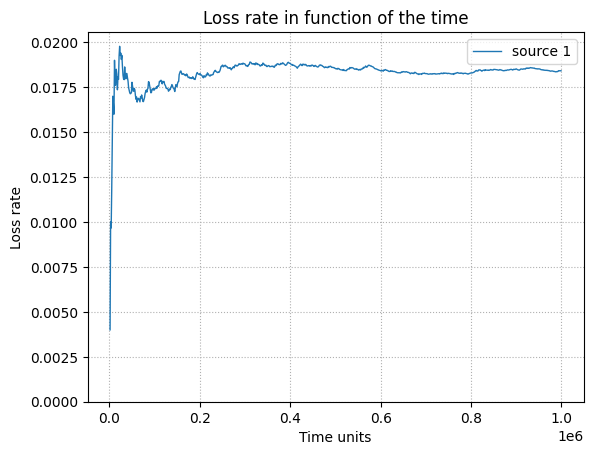

In [171]:
plt.plot(df_lossRates[df_lossRates['sourceId'] == 1]['time'], df_lossRates[df_lossRates['sourceId'] == 1]['lossRate'], linewidth=1, label='source 1')
plt.grid(True, which="both", ls="dotted")
plt.ylim(ymin=0)
plt.ylabel('Loss rate')
plt.xlabel('Time units')
plt.title('Loss rate in function of the time')
plt.legend()
plt.show()

In [172]:
env_2 = simpy.Environment()

q_det = queueClass(env_2, 10, 1.0, exp_service=False)
scen_2 = poissonSource(env_2, 0.8, q_det, 2, 1)

env_2.run(until=simulationDuration)

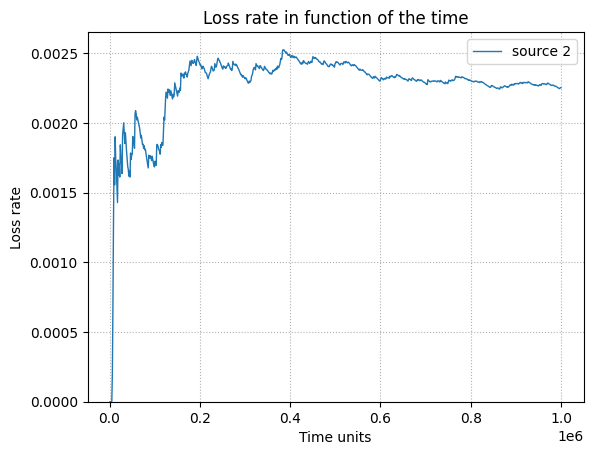

In [173]:
plt.plot(df_lossRates[df_lossRates['sourceId'] == 2]['time'], df_lossRates[df_lossRates['sourceId'] == 2]['lossRate'], linewidth=1, label='source ' + str(2))
plt.grid(True, which="both", ls="dotted")
plt.ylim(ymin=0)
plt.ylabel('Loss rate')
plt.xlabel('Time units')
plt.title('Loss rate in function of the time')
plt.legend()
plt.show()

In [174]:
env_3 = simpy.Environment()

q_exp_3 = queueClass(env_3, 10, 1.0)
scen_3 = poissonSource(env_3, 0.1, q_exp_3, 3, 1)
scen_4 = poissonSource(env_3, 0.7, q_exp_3, 4, 1)

env_3.run(until=simulationDuration)

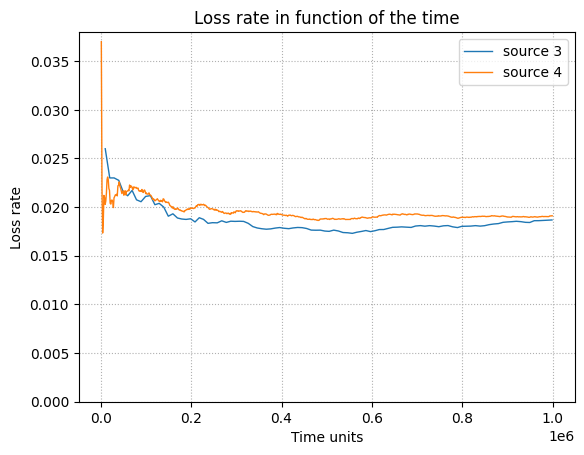

In [175]:
plt.plot(df_lossRates[df_lossRates['sourceId'] == 3]['time'], df_lossRates[df_lossRates['sourceId'] == 3]['lossRate'], linewidth=1, label='source ' + str(3))
plt.plot(df_lossRates[df_lossRates['sourceId'] == 4]['time'], df_lossRates[df_lossRates['sourceId'] == 4]['lossRate'], linewidth=1, label='source ' + str(4))
plt.grid(True, which="both", ls="dotted")
plt.ylim(ymin=0)
plt.ylabel('Loss rate')
plt.xlabel('Time units')
plt.title('Loss rate in function of the time')
plt.legend()
plt.show()

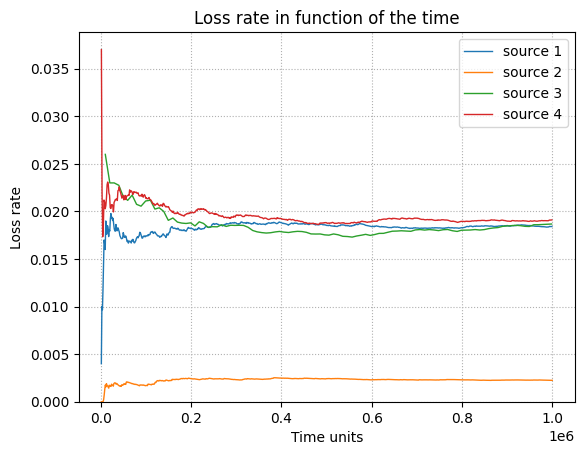

In [176]:
for i in range(1, 5):
    plt.plot(df_lossRates[df_lossRates['sourceId'] == i]['time'], df_lossRates[df_lossRates['sourceId'] == i]['lossRate'], linewidth=1, label='source ' + str(i))

plt.grid(True, which="both", ls="dotted")
plt.ylim(ymin=0)
plt.ylabel('Loss rate')
plt.xlabel('Time units')
plt.title('Loss rate in function of the time')
plt.legend()
plt.show()

In [177]:
df_scenarios = pd.DataFrame(columns=['sourceId', 'rate', 'meanLossRate'])


### Class 02 - Confidence Intervals


In [178]:
std_dev = df_lossRates_mean[df_lossRates_mean['sourceId'] == 1]['meanLossRate'].std()
epsilon_tal = 4.5 * std_dev
epsilon_t = epsilon_tal * math.sqrt(block_size/simulationDuration)
df_results = pd.DataFrame(columns=['sourceId', 'mean', 'stdDev', 'epsilon_tal', 'epsilon_t', 'eps_t/mean'])
for sourceId in range(1, 5):
    mean = df_lossRates[df_lossRates['sourceId'] == sourceId]['lossRate'].mean()
    std_dev = df_lossRates_mean[df_lossRates_mean['sourceId'] == sourceId]['meanLossRate'].std()
    epsilon_tal = 4.5 * std_dev
    epsilon_t = epsilon_tal * math.sqrt(block_size/simulationDuration)
    df_results.loc[len(df_results)] = {'sourceId': sourceId, 'mean': mean, 'stdDev': std_dev, 'epsilon_tal': epsilon_tal, 'epsilon_t': epsilon_t, 'eps_t/mean': epsilon_t/mean}

df_results


,sourceId,mean,stdDev,epsilon_tal,epsilon_t,eps_t/mean
0,1,0.018291,0.000668,0.003004,0.000010,0.000519
1,2,0.002266,0.000254,0.001141,0.000004,0.001592
2,3,0.018614,0.001372,0.006173,0.000020,0.001049
3,4,0.019527,0.000894,0.004025,0.000013,0.000652


In [180]:
# search for rows where ci is different from 0
df_lossRates[df_lossRates['ci'] != 0]

,sourceId,time,lossRate,ci
10,1,13694.117361,0.017636,0.066462
11,1,14993.701967,0.018500,0.066462
12,1,16284.631767,0.018231,0.066462
13,1,17516.777676,0.017357,0.066462
14,1,18760.004672,0.018067,0.066462
...,...,...,...,...
2391,4,994588.337739,0.019096,0.000145
2392,4,996008.289436,0.019090,0.000145
2393,4,997424.969394,0.019110,0.000145
2394,3,998266.786162,0.018680,0.002343


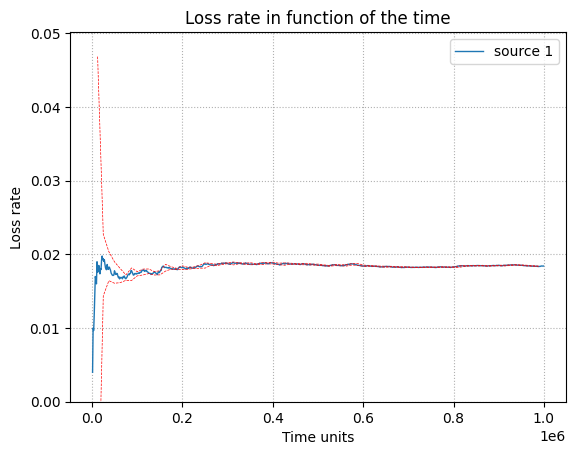

In [181]:
# Plot source 1 loss rate with lines of confidence interval
plt.plot(df_lossRates[df_lossRates['sourceId'] == 1]['time'], df_lossRates[df_lossRates['sourceId'] == 1]['lossRate'], linewidth=1, label='source 1')
plt.plot(df_lossRates_mean[df_lossRates_mean['sourceId'] == 1]['time'], df_lossRates_mean[df_lossRates_mean['sourceId'] == 1]['epsilon_t']/2 + df_lossRates_mean[df_lossRates_mean['sourceId'] == 1]['meanLossRate'], 'r--', linewidth=0.5)
plt.plot(df_lossRates_mean[df_lossRates_mean['sourceId'] == 1]['time'], df_lossRates_mean[df_lossRates_mean['sourceId'] == 1]['meanLossRate'] - df_lossRates_mean[df_lossRates_mean['sourceId'] == 1]['epsilon_t']/2, 'r--', linewidth=0.5)
plt.grid(True, which="both", ls="dotted")
plt.ylim(ymin=0)
plt.ylabel('Loss rate')
plt.xlabel('Time units')
plt.title('Loss rate in function of the time')
plt.legend()
plt.show()